# Variational Quantum Eigensolver (VQE)

A variational quantum eigensolver is a variational quantum algorithm where a parametrized quantum circuit is trained to prepare the ground state of a target Hamiltonian [See A. Peruzzo et al. - 2013](https://arxiv.org/abs/1304.3061).

<img src="./figures/vqe.png" width="800" height="500" alt="My Image">

As sketched above, the idea is that we get a state from a quantum circuit, and this state depends on the parameters of the circuit. Then we implement a machine learning routine to update the parameters of the circuit such that the expectation value of our target Hamiltonian on this state is minimized.

<div style="background-color: rgba(255, 105, 105, 0.3); border: 2.5px solid #000000; padding: 15px;">
    <strong>Exercise:</strong> 
    Solve the Grover problem using a VQE. Suppose that you want to find the $i$-th item in a database of $2^n$ items. To do that you have to formulate the problem as an energy minimization problem: you first define an Hamiltonian which encodes in its ground state the $i$-th item you are interested in, then you train your QML model to miminize the expectation value of such Hamiltonian.
    
</div>

### Problem's Hamiltonian
First you'll have to come up with the Hamiltonian form that solves the problem, i.e. that encodes the i-th item in its ground state. 
You can use ``qibo``'s ``SymbolicHamiltonian`` and symbols to define the form of your Grover's Hamiltonian.

In [1]:
from qibo.hamiltonians import SymbolicHamiltonian
from qibo.symbols import Z, I

# this creates a Z0 * I1 operator, i.e. a tensor product between a pauli Z
# on the first qubit and the identity on the second qubit
form = Z(0) * I(1)
# you can also add other terms
form += 1 - Z(2) * (1 + I(0) * Z(1) * Z(2))
H = SymbolicHamiltonian(form, nqubits=3)
H.form

[Qibo 0.2.20|INFO|2025-07-18 17:18:18]: Using qibojit (cupy) backend on /GPU:0


1 + Z0*I1 - Z2*(1 + I0*Z1*Z2)

**hint 1:** 

<details>
<summary> show </summary>
If you represent items in the database as bitstrings, then supposing the item you're looking for corresponds to the state with $| x^\ast \rangle = | x_0x_1 ... x_n \rangle$, you may want to write the projector onto that state.
</details>

**hint 2:** 

<details>
<summary> show </summary>
The projector you need is therefore $| x^\ast \rangle \langle x^\ast|$ and you can build the hamiltonian as: 
    $$H = 1 - | x^\ast \rangle \langle x^\ast |$$ 
which, since $x^\ast$ is a string of bits, can be written in terms of $Z$ pauli operators as:
    $$H = 1 - \bigotimes_i \bigg( 1 + (-1)^{x_i} Z_i \bigg)$$
where the $x_i$ are the bits composing $x^\ast$.
</details>

In [2]:
# item to find
item_index = 11 
# database dimension
n_items = 32
# how many qubits do we need?
# use the minimum number of qubits possible!
nqubits = 10

# define a function that takes item_index and n_items
# as inputs and produces the Grover Hamiltonian
def grover_hamiltonian(item_index: int, n_items: int) -> SymbolicHamiltonian:
    pass

H = grover_hamiltonian(item_index, n_items)

### Build the QML model and train it!

Now that we have the Hamiltonian, you can build the desired QML model using the tools introduced in the previous notebook. You can always use the ``HardwareEfficient`` ansatz to build the core of your model if you like, or you can come up with your custom parametrized circuit, but do you actually need any encoder in this case?

2025-07-18 17:18:19.298952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752851899.310909    9810 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752851899.314602    9810 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752851899.324954    9810 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752851899.324965    9810 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752851899.324966    9810 computation_placer.cc:177] computation placer alr


 -> We were looking for item: 0000001011


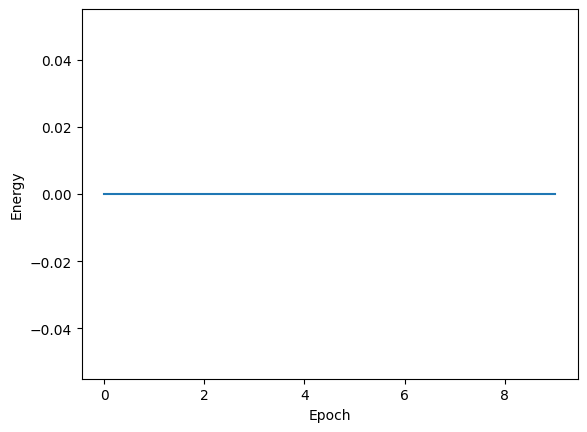

In [3]:
from qiboml.interfaces.pytorch import QuantumModel
from qibo.ui.result_visualization import visualize_state
import matplotlib.pyplot as plt

# define the parametric parts 
circuit_structure = []
# define the decoding strategy
decoder = None

# build your quantum model
#model = QuantumModel(
#   circuit_structure,
#   decoder
#)

# train the model
n_epochs = 10
energy_history = []
for epoch in range(n_epochs):
    # ... 
    # ...
    # save the current energy
    energy = 0.
    energy_history.append(energy)

plt.plot(energy_history)
plt.ylabel("Energy")
plt.xlabel("Epoch")

# this is the item we were looking for
print(f"\n -> We were looking for item: {item_index:0{nqubits}b}")

# uncomment this to check which item your model found
# `circuit` should be the parametric circuit that you 
# built the QuantumModel with
#visualize_state(circuit())


### Fetching multiple items

<div style="background-color: rgba(255, 105, 105, 0.3); border: 2.5px solid #000000; padding: 15px;">
    <strong>Exercise:</strong> 
    What if instead we wanted to retrieve multiple items at once?
</div>

In [4]:
item_indices = [31, 7, 16]
n_items = 32

# define a function that takes a list of indices, item_indices, and n_items
# as inputs and produces the Hamiltonian
def multi_grover_hamiltonian(item_indices: list[int], n_items: int) -> SymbolicHamiltonian:
    pass


 -> We were looking for items: ['0000011111', '0000000111', '0000010000']


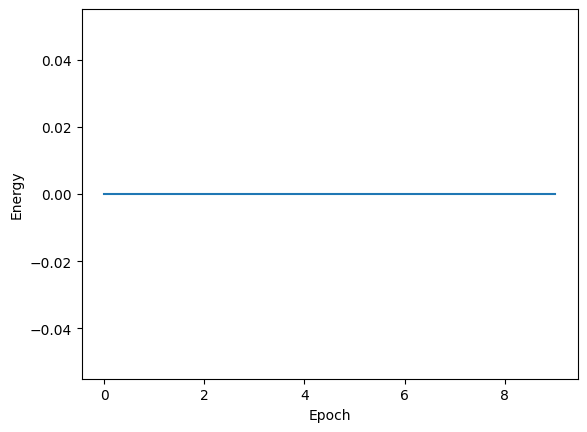

In [5]:
# define the parametric parts 
circuit_structure = []
# define the decoding strategy
decoder = None

# build your quantum model
#model = QuantumModel(
#   circuit_structure,
#   decoder
#)

# train the model
n_epochs = 10
energy_history = []
for epoch in range(n_epochs):
    # ... 
    # ...
    # save the current energy
    energy = 0.
    energy_history.append(energy)

plt.plot(energy_history)
plt.ylabel("Energy")
plt.xlabel("Epoch")

# these are the items we were looking for
bitstrings = [f"{index:0{nqubits}b}" for index in item_indices]
print(f"\n -> We were looking for items: {bitstrings}")

# uncomment this to check which items your model found
# `circuit` should be the parametric circuit that you 
# built the QuantumModel with
#visualize_state(circuit())